# Tweets Analyze
Twitter is important social media nowadays. Many companies conduct their advertising
campaigns there to reach their customers. The question is: Can We see what's inside heads
of thousands of people. Access to that knowledge can result in better market understanding,
advertisement targeting and mostly important - our customers behaviour.

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
from scripts.nlp import TweetNormalizer, SentimentAnalyzer, TopWords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
import pyLDAvis
import pyLDAvis.sklearn
from pickle import dump
import warnings

pyLDAvis.enable_notebook()
warnings.filterwarnings('ignore', category=DeprecationWarning)  # There is issue with ipython and pyLDAvis
pd.options.display.float_format = '{:.2f}'.format

### Loading data
Data has been collected through Twitter API and Tweepy library. Script to get new data
can be found in ~/scripts/TwitterCollector.py To get new data call there
```console
$ python TwitterCollector.py <query search> <number of items to look for>
```
I'm going to change data types of loaded dataset and display quick summaries.

In [2]:
df = pd.read_csv('../data/tweets.csv')

df['Full_text'] = df['Full_text'].astype('string')
df[['Retweet_count', 'Favorite_count']] = df[['Retweet_count', 'Favorite_count']].astype('int')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13122 entries, 0 to 13121
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Full_text       13122 non-null  string
 1   Retweet_count   13122 non-null  int64 
 2   Favorite_count  13122 non-null  int64 
dtypes: int64(2), string(1)
memory usage: 307.7 KB


In [3]:
df.head(10)

,Full_text,Retweet_count,Favorite_count
0,@dprice2413 @Nicki_coming @playboiprint @jethm...,0,0
1,Updated: Nokia Mobile smartphones Android 11 u...,3,72
2,@girlsinrap @itslakeyah When will Nokia?,0,0
3,Turkish Nokia Style Ringtone 2021 #MIvsRCB #M...,1,0
4,I suddenly miss transferring songs via bluetoo...,0,5
5,@_AshleyChristie listen this photo is like 5 y...,0,1
6,RT @Gadgets360: Flipkart has launched two pair...,6,0
7,I so wanted to like #lovetrustkeep by @NokiaMo...,1,1
8,RT @rockleaks: Nokia C20 gets Bluetooth certif...,1,0
9,Flipkart Launches Nokia Bluetooth Neckband &am...,0,0


We can see that many tweets have both 0 retweets nad likes,
but there are some really popular among others

In [4]:
df.describe()

,Retweet_count,Favorite_count
count,13122.00,13122.00
mean,97.36,5.13
std,2014.16,114.91
min,0.00,0.00
25%,0.00,0.00
50%,0.00,0.00
75%,0.00,1.00
max,103343.00,11708.00


### Data normalization
I've built custom sklearn transformer class to preprocess tweets. It consists of
* removing urls, hashtags and random punctuation
* removing stopwords
* building bag of words model as intermediate step
* lemmatization through WordNetLemmatizer


In [5]:
normalizer = TweetNormalizer()
df['Preprocessed_text'] = normalizer.fit_transform(df['Full_text'])

df['Preprocessed_text'].head()

0                                          maybe nokia
1    updated nokia mobile smartphones android 11 up...
2                                                nokia
3    turkish nokia style ringtone 2021 mivsrcb mist...
4    suddenly miss transferring song via bluetooth ...
Name: Preprocessed_text, dtype: object

### Sentiment intensity analyze
I'm going to use sklearn wrapper I've built for nltk.sentiment.vader Sentiment Analyzer. It was trained
to be used on text data from social media, products reviews and news editorials. One of it's
advantages is speed, so It can be used with online streaming data.

In [6]:
sa = SentimentAnalyzer()

sentiment = sa.fit_predict(df['Preprocessed_text'])
df[['Negative', 'Neutral', 'Positive', 'Compound']] = pd.DataFrame.from_records(sentiment)

df[['Negative', 'Neutral', 'Positive']].describe()

,Negative,Neutral,Positive
count,13122.00,13122.00,13122.00
mean,0.05,0.81,0.14
std,0.12,0.20,0.18
min,0.00,0.00,0.00
25%,0.00,0.66,0.00
50%,0.00,0.84,0.00
75%,0.00,1.00,0.24
max,1.00,1.00,1.00


We can see that most tweets are either neutral or positive with small number of negative ones

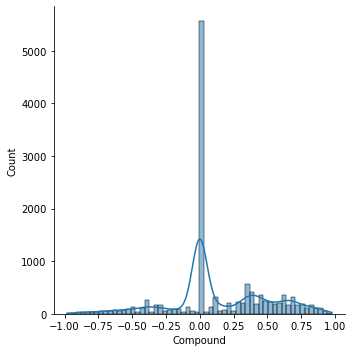

In [7]:
sns.displot(data=df, x='Compound', kde=True);

### Text vectorization
I'm going to use default sklearn TfidVectorizer.

In [8]:
vectorizer = TfidfVectorizer()
words = vectorizer.fit_transform(df['Preprocessed_text'])

### Topic modeling
Latent Dirichlet Allocation algorithm is really handy when It comes to topic modeling.
It belongs to family of unsupervised learning algorithms, used among others to matrix factorization
problems. LDA decompose document-words matrix to documents-topic matrix (probabilities of belonging document to each topic)
and words-topic matrix (importance of each word in each topic).

In [9]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
topic = lda.fit_transform(words)

df['Topic'] = [np.argmax(prob) for prob in topic]

I'm going also to extract most important words for each topic

In [10]:
top = TopWords(vectorizer, lda, 10)
words_top = top.fit_predict(topic)

### Topic model visualization
Since, the output of topic modeling is high dimensionality data, It needs to be projected
onto lower dimension plate. One of the most popular tools for visualizing that kind of data
is t-SNE model. It converts similarities between data points to joint probabilities what result in
reduces of dimensions.

In [11]:
tsne = TSNE(n_components=2)
projection = tsne.fit_transform(topic)

df[['X-tsne', 'Y-tsne']] = projection

There is very cool package called pyLDAvis to visualize topics distribution.

In [12]:
fig = pyLDAvis.sklearn.prepare(lda, words, vectorizer)
fig

PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
0     -0.11  0.08       1        1 33.58
3      0.16  0.08       2        1 21.62
4     -0.07  0.03       3        1 19.73
2      0.02 -0.08       4        1 12.63
1      0.00 -0.12       5        1 12.45, topic_info=          Term   Freq  Total Category  logprob  loglift
120         11  92.00  92.00  Default    30.00    30.00
1868   android 152.00 152.00  Default    29.00    29.00
6528      game  69.00  69.00  Default    28.00    28.00
11354   patent  50.00  50.00  Default    27.00    27.00
8872    lenovo  52.00  52.00  Default    26.00    26.00
...        ...    ...    ...      ...      ...      ...
9331    making   9.66  21.44   Topic5    -6.21     1.29
11448   people  11.37  33.77   Topic5    -6.04     0.99
1819       amp  12.66  71.28   Topic5    -5.94     0.36
13116       rt  17.09 213.33   Topic5    -5.64    -0.44
10336     next   9.20  34.65   Topic5    -6.25     0.76

[325 rows x 6 columns], token_table=       Topic  Freq     Term
term                       
15         5  0.87       02
20         5  0.86       03
26         5  0.87       04
32         5  0.99       05
37         5  0.98       06
...      ...   ...      ...
16708      1  0.92   xpress
16715      2  0.93  xseries
16756      1  0.58     year
16756      2  0.23     year
16756      3  0.19     year

[562 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 5, 3, 2])

### Pipelines, saving models
There are 3 pipelines to process data to different outputs. I have also saved already
processed data. All of that are going to be used in ,,What Twitter thinks about company" dashboard

In [13]:
sentiment_steps = [('normalizer', normalizer), ('sentiment', sa)]
sentiment_pipeline = Pipeline(sentiment_steps)

words_steps = [('normalizer', normalizer), ('vectorizer', vectorizer), ('lda', lda), ('top_words', top)]
words_pipeline = Pipeline(words_steps)

tsne_steps = [('normalizer', normalizer), ('vectorizer', vectorizer), ('lda', lda), ('tsne', tsne)]
tsne_pipeline=Pipeline(tsne_steps)

dump(sentiment_pipeline, open('../models/sentiment_pipeline.pkl', 'wb'))
dump(words_pipeline, open('../models/words_pipeline.pkl', 'wb'))
dump(tsne_pipeline, open('../models/tsne_pipeline.pkl', 'wb'))

json.dump(words_top, open('../dashboard/words_top.json', 'w'))
df.to_csv('../dashboard/tweets_nlp.csv')
